In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import math

## Generate some training data ##

In [64]:
np.random.seed(666)

def generate_data(num_samples):

    radius = 5
    data = []
    labels = []

    # generate positive samples with label 1
    for i in range(num_samples//2):
        r = np.random.uniform(0, radius*0.5)
        theta = np.random.uniform(0, 2*np.pi)
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        data.append([x,y])
        labels.append(1)

    # generate negative samples with label 0
    for i in range(num_samples//2):
        r = np.random.uniform(radius*0.7, radius)
        theta = np.random.uniform(0, 2*np.pi)
        x = r*np.cos(theta)
        y = r*np.sin(theta)
        data.append([x,y])
        labels.append(0)

    data = np.asarray(data)
    labels = np.asarray(labels)

    return data, labels

num_samples = 500
my_data, my_labels = generate_data(num_samples)

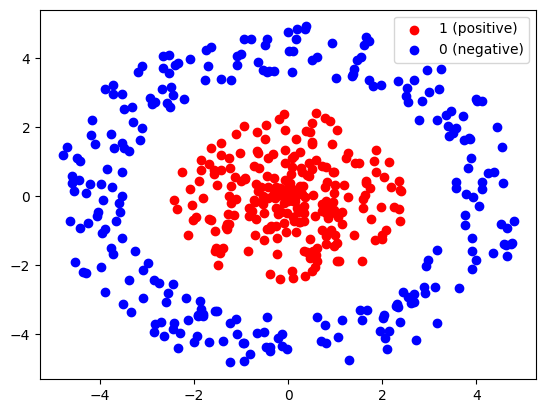

In [24]:
plt.scatter(my_data[:num_samples//2,0], my_data[:num_samples//2,1], color = "red", label = "1 (positive)")
plt.scatter(my_data[num_samples//2:,0], my_data[num_samples//2:,1], color = "blue", label = "0 (negative)")
plt.legend(loc = "upper right")
plt.show()

## Network Architechture ##

We'll use a nueral network with a single hidden layer with 3 units. Hidden layer activation will be $\mathrm{tanh}(\cdot)$ and output layer activation will be $\sigma(\cdot)$ (sigmoid activation) as we are dealing with binary classification. Define
$$
    D^{\text{train}} = \{(\mathbf{x}^{(i)}, t^{(i)})\}_{i=1}^N \subseteq \mathbb{R}^2 \times \{0,1\}
$$
Where $N = \texttt{num_samples}$. Given an input vector $\mathbf{x} \in \mathbb{R}^2$, we seek to predict $\mathbb{P}(t = 1|\mathbf{x})$, namely our network outputs a probability distribution. The forward pass for a feature vector $\mathbf{x}$ is


\begin{align*}
    \mathbf{u}^{(1)} &= W^{(1)}\mathbf{x} + \mathbf{b}^{(1)} \\
    \mathbf{h}^{(1)} &= \mathrm{tanh}(\mathbf{u}^{(1)}) \\
    z &= W^{(2)}\mathbf{h}^{(1)} + b^{(2)} \\
    y &= \sigma(z)
\end{align*}

Where $W^{(1)} \in \mathbb{R}^{3\times 2}, \mathbf{b}^{(1)} \in \mathbb{R}^3, W^{(2)} \in \mathbb{R}^{1\times 3}$ and $b^{(2)} \in \mathbb{R}$. The forward pass in matrix form is then

\begin{align*}
    U^{(1)} &= XW^{(1)^T} + \mathbf{1}\mathbf{b}^{(1)^T} \\
    H^{(1)} &= \mathrm{tanh}(U^{(1)}) \\
    \mathbf{z} &= H^{(1)}W^{(2)^T} + \mathbf{1}b^{(2)} \\
    \mathbf{y} &= \sigma(\mathbf{z})
\end{align*}

In [75]:
# code forward pass
params = {}
params["W_1"] = np.random.randn(3,2)
params["b_1"] = np.zeros(3)
params["W_2"] = np.random.randn(3)
params["b_2"] = 0

def forward(X, params):
    G_1 = np.dot(X, params["W_1"].T) + params["b_1"]
    H_1 = np.tanh(G_1)
    z = np.dot(H_1, params["W_2"].T) + params["b_2"]
    y = sigmoid(z)

    return y

## Loss function and Backpropogation equations ##

The loss function that we'll be using is logistic cross-entropy, defined by
$$
\mathcal{L}_{\mathrm{LCE}}(z,t) = t\log(1 + e^{-z}) + (1 -t)\log(1 + e^z)
$$
Averaging the individual training losses over the entire training set gives us the cost function
$$
\mathcal{E}(\mathbf{z}, \mathbf{t}) = \frac{1}{N}\sum_{i=1}^N \mathcal{L}_{\mathrm{LCE}}(z_i, t_i)
$$

this $\overline{\mathbf{z}}$

The vectorized backpropogation equations are has follows
\begin{align*}
    \overline{\mathbf{z}} &= \frac{1}{N}(\mathbf{y} - \mathbf{t}) \\
    \overline{W^{(2)}} &= H^T\overline{\mathbf{z}} \\
    \overline{\mathbf{b}^{(2)}} &= \overline{\mathbf{z}}^T\mathbf{1} \\
    \overline{H^{(1)}} &= \overline{\mathbf{z}}W^{(2)} \\
    \overline{G^{(1)}} &= \overline{H^{(1)}} \odot(1 - \mathrm{tanh}(G^{(1)})) \\
    \overline{W^{(1)}} &= \overline{G^{(1)}}^TX\\
    \overline{b^{(1)}} &= \overline{G^{(1)}}^T\mathbf{1}
\end{align*}

In [78]:
def backprop(X, t, params):

    N = X.shape[0]

    # compute forward pass
    G_1 = np.dot(X, params["W_1"].T) + params["b_1"]
    H_1 = np.tanh(G_1)
    z = np.dot(H_1, params["W_2"].T) + params["b_2"]
    y = sigmoid(z)
    loss = np.sum(-t*np.log(y) - (1-t)*np.log(1-y))/N

    # compute backwards pass
    z_bar = (y - t)/N
    W_2_bar = np.dot(H_1.T, z_bar)
    b_2_bar = np.dot(z_bar, np.ones(N))
    H_1_bar = np.outer(z_bar, params["W_2"].T)
    G_1_bar = H_1_bar*(1 - np.tanh(G_1)**2)
    W_1_bar = np.dot(G_1_bar.T, X)
    b_1_bar = np.dot(G_1_bar.T, np.ones(N))

    grads = {}
    grads["W_1"] = W_1_bar
    grads["b_1"] = b_1_bar
    grads["W_2"] = W_2_bar
    grads["b_2"] = b_2_bar

    return grads, loss

## Model fitting and gradient descent ##

In [79]:
# implement gradient descent using the derivatives computed above

num_steps =  1000
alpha = 1
for step in range(num_steps):
    grads, loss = backprop(my_data, my_labels, params)
    for k in params:
        params[k] -= alpha*grads[k]

    if not step % 50:
        print("Step {v1} | Loss {v2}".format(v1 = step, v2 = loss))


Step 0 | Loss 0.7353436008874695
Step 50 | Loss 0.28138790124639107
Step 100 | Loss 0.15649482089920988
Step 150 | Loss 0.11206885458963131
Step 200 | Loss 0.08977741905321898
Step 250 | Loss 0.07630525597929641
Step 300 | Loss 0.0674092197564446
Step 350 | Loss 0.0611694791926341
Step 400 | Loss 0.05648642508286688
Step 450 | Loss 0.05277985114170416
Step 500 | Loss 0.04973156882364026
Step 550 | Loss 0.04714990468100242
Step 600 | Loss 0.04491232088397986
Step 650 | Loss 0.04293729233365203
Step 700 | Loss 0.04116877597541882
Step 750 | Loss 0.039567096352563356
Step 800 | Loss 0.0381033842118603
Step 850 | Loss 0.03675608446990095
Step 900 | Loss 0.03550871327403067
Step 950 | Loss 0.03434838733755862


<ipython-input-85-0e4b80b9027a>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('hot'))


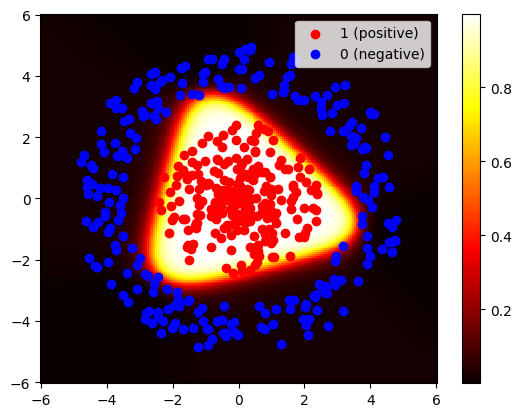

In [85]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
Y = forward(points, params).reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('hot'))
plt.colorbar()
plt.scatter(my_data[:num_samples//2, 0], my_data[:num_samples//2, 1], color='red', label = "1 (positive)")
plt.scatter(my_data[num_samples//2:, 0], my_data[num_samples//2:, 1], color='blue', label = "0 (negative)")
plt.legend(loc = "upper right")
plt.show()
